<a href="https://colab.research.google.com/github/dffesalbon/bert-lexicon-sentiment-analysis-i/blob/bert-uncased/bert-uncased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet wandb
!pip install --quiet transformers
!pip install --quiet datasets
!pip install --quiet emoji
!pip install --quiet kaggle
!pip install --quiet torchinfo
!pip install --quiet imbalanced-learn
!pip install --quiet gdown

!pip install --quiet clean-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 KB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 9.1 MB/s eta 0:

In [ ]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
import transformers
from transformers import AutoTokenizer
from transformers import BertConfig
from transformers.models.bert.modeling_bert import BertModel, BertPreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import AutoConfig
from transformers import Trainer, TrainingArguments
from transformers import get_scheduler

import wandb

from torch.optim import AdamW
import torch.nn as nn
from torch.utils import data

# dataset
import datasets
from datasets import Dataset , Sequence , Value , Features , ClassLabel , DatasetDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# preprocessing
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize

import re, string
import emoji

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# list of pretrained models: https://huggingface.co/transformers/v3.3.1/pretrained_models.html
models = ["distilbert-base-uncased", "bert-base-uncased", "bert-base-cased"]
model_name = models[1]

class_names = ['Non-toxic', 'Toxic']
max_len = 64

In [ ]:
def clean_text(text):
    text = re.sub('#', '', text) # Removing '#' hashtag
    text = re.sub('\w+:\/\/\S+', '', text) # Removing hyperlink
    text = re.sub('[^a-zA-Z]', ' ', text) # Remove punctuation
    text.lower()
    return text

In [ ]:
def clean_text(text):
    text = re.sub('#', '', text) # Removing '#' hashtag
    text = re.sub('\w+:\/\/\S+', '', text) # Removing hyperlink
    text = re.sub('[^a-zA-Z]', ' ', text) # Remove punctuation
    text.lower()
    return text

In [ ]:
train = pd.read_csv('/content/sample_data/train.csv')
test = pd.read_csv('/content/sample_data/test.csv')

In [ ]:
train.loc[:,'texts'] = train['texts'].apply(lambda x : clean_text(x))
test.loc[:,'texts'] = test['texts'].apply(lambda x : clean_text(x))

In [ ]:
train, val = train_test_split(train, test_size=0.1, random_state=RANDOM_SEED, stratify=train['target'])

In [ ]:
def create_dataset(df, text, label):
  dataset_dict = {'text':df[text], 'labels':df[label]}
  tags = ClassLabel(num_classes=2 , names=class_names)

  return Dataset.from_dict(
    mapping = dataset_dict,
    features = Features({'text':Value(dtype='string'), 'labels':tags})
  )

In [ ]:
dataset_train = create_dataset(train,"texts","target")
dataset_val = create_dataset(val,"texts","target")
dataset_test = create_dataset(test,"texts","target")

In [ ]:
dataset_chat_analysis = DatasetDict()
dataset_chat_analysis["train"] = dataset_train
dataset_chat_analysis["val"] = dataset_val
dataset_chat_analysis["test"] = dataset_test

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=max_len)

In [ ]:
sample_text = "What is  going on @resturant.:( It makes   Me Feel Upset.😞"
tokens = tokenizer.tokenize(sample_text)
print(len(tokens), tokens)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(len(token_ids), token_ids)

token_dictionary = tokenizer(sample_text)
print(token_dictionary)
print(len(token_dictionary.input_ids)) # automatically added cls, sep

tokens = tokenizer.convert_ids_to_tokens(token_dictionary['input_ids'])
print(tokens)

token_encode = tokenizer.encode(sample_text) #convert to tokens ids but with cls+sep
print(token_encode)

18 ['what', 'is', 'going', 'on', '@', 'rest', '##ura', '##nt', '.', ':', '(', 'it', 'makes', 'me', 'feel', 'upset', '.', '[UNK]']
18 [2054, 2003, 2183, 2006, 1030, 2717, 4648, 3372, 1012, 1024, 1006, 2009, 3084, 2033, 2514, 6314, 1012, 100]
{'input_ids': [101, 2054, 2003, 2183, 2006, 1030, 2717, 4648, 3372, 1012, 1024, 1006, 2009, 3084, 2033, 2514, 6314, 1012, 100, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
20
['[CLS]', 'what', 'is', 'going', 'on', '@', 'rest', '##ura', '##nt', '.', ':', '(', 'it', 'makes', 'me', 'feel', 'upset', '.', '[UNK]', '[SEP]']
[101, 2054, 2003, 2183, 2006, 1030, 2717, 4648, 3372, 1012, 1024, 1006, 2009, 3084, 2033, 2514, 6314, 1012, 100, 102]


In [ ]:
# we use special tokens to separate the sentences. How bert works
#print(tokenizer)
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [ ]:
# the inputs same as distilbert_tokenizer()
encoding = tokenizer.encode_plus(
    sample_text,
    max_length=max_len,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors="pt"
)
#encoding

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
encoded = dataset_chat_analysis.map(tokenize, batched=True, batch_size=32)

  0%|          | 0/46 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

In [ ]:
class BertForClassification(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        # Load model body > return all og the HS
        self.bert = BertModel(config)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()


    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.bert(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)

        # Apply classifier to encoder representation > [cls]
        sequence_output = self.dropout(outputs[1])
        logits = self.classifier(sequence_output)

        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
id2label = {0:'Non-toxic', 1:'Toxic'}
label2id = { v:k for (k,v) in id2label.items()}

bert_config = AutoConfig.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)
bert_model = (BertForClassification.from_pretrained(model_name, config=bert_config).to(device))

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForClassification were not initialized from the model checkpoint at bert-base-uncased and are newly

In [ ]:
! wandb login fa19cfab8c0967bc35372f9f40932d67154809a9

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.login()

wandb.init(project="bert-for-english-classification")

batch_size = 16
logging_steps = len(encoded["train"]) // batch_size
model_name = f"{model_name}-fine-tuned-dota-chat-en-bert-cased"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch", 
                                  save_steps=1e6,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error",
                                  report_to="wandb",
                                  run_name="bert-sent-analysis")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
optimizer = AdamW(bert_model.parameters(), lr=2e-5)

num_epochs = 10
num_training_steps = num_epochs * logging_steps
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

trainer_preprocessed_lr = Trainer(model=bert_model, args=training_args,
                                  compute_metrics=compute_metrics,
                                  train_dataset=encoded["train"],
                                  eval_dataset=encoded["val"],
                                  tokenizer=tokenizer,
                                  optimizers=(optimizer,lr_scheduler))

trainer_preprocessed_lr.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.456500,0.338983,0.875776,0.875632
2,0.250900,0.302343,0.888199,0.888017
3,0.135000,0.287279,0.919255,0.919236
4,0.080600,0.330072,0.913043,0.912976
5,0.038100,0.452157,0.894410,0.894402


TrainOutput(global_step=455, training_loss=0.19050934652050772, metrics={'train_runtime': 6259.0837, 'train_samples_per_second': 1.157, 'train_steps_per_second': 0.073, 'total_flos': 238115505100800.0, 'train_loss': 0.19050934652050772, 'epoch': 5.0})

In [ ]:
model = bert_model
model.eval()
preds_output = trainer_preprocessed_lr.predict(encoded["test"])
pd.DataFrame(list(preds_output.metrics.items())).T

,0,1,2,3,4,5
0,test_loss,test_accuracy,test_f1,test_runtime,test_samples_per_second,test_steps_per_second
1,0.859589,0.828678,0.828453,109.641,4.898,0.31


In [ ]:
PATH = "/content/sample_data/bert-classification-classification-head-uncased"
torch.save(bert_model.state_dict(), PATH)

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

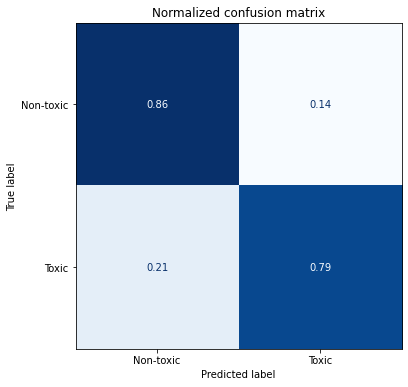

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_test = np.array(encoded["test"]["labels"])
labels = encoded["train"].features["labels"].names
plot_confusion_matrix(y_preds, y_test, labels)

In [ ]:
print(classification_report(y_test, y_preds, target_names=class_names))

              precision    recall  f1-score   support

   Non-toxic       0.81      0.86      0.84       270
       Toxic       0.85      0.79      0.82       267

    accuracy                           0.83       537
   macro avg       0.83      0.83      0.83       537
weighted avg       0.83      0.83      0.83       537



In [ ]:
trainer_preprocessed_lr.save_model('/content/sample_data/dota-chat-bert-model-uncased')